# Lunar Lander from OpenAI

This notebook is heavily inspired by the exercise notebook from DeepLearning.AI course: Reinforcement Learning

I have added extra packages and some line of comments to make it easier to understand the code. It took quite a bit of time messing around with the code since there are some changes to the LunarLander package (I guess?)

Course link: https://www.coursera.org/learn/unsupervised-learning-recommenders-reinforcement-learning

## Import dependencies

In [1]:
!python --version

Python 3.10.12


In [2]:
# have to install swig to build box2d-py from source
!pip install swig
!pip install box2d-py
!pip install gym[box2d]

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 23.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 374.5/374.5 kB 8.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... - \ done
  Created wheel for box2d-py: filename=box2d_py-2.3.8-cp310-cp310-linux_x86_64.whl size=495295 sha256=5d2ef9af8a3f27b8d9e56da2d8d62be99713d6543189da0503226cfa5084af98
  Stored in directory: /root/.cache/pip/wheels/47/01/d2/6a780da77ccb98b1d2facdd520a8d10838a03b590f6f8d50c0
Successfully built box2d-py
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 374.4/374.4 kB 8.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... - \ done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.3/18.3 MB 47.0 MB/s eta 0:00:00
  Created wheel for box2d-py: filename=box2d_py-2.3.5-cp310-cp310-linux_x86_64.whl size=495294 sha256=fb98c67104785d1b238fdee8dbc971bef2a16794b808bcb1e6ef6b6626806625
  Stored in directory: /root/.cache/pip/wheels/db/8f/6a/eaaadf056fba10a98d986f6dce954e6201ba3126926fc5ad9e
Succ

In [3]:
# need to install old libraries to export videos at 30fps
!pip install imageio==2.19.3
!pip install imageio-ffmpeg==0.4.7

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.4/3.4 MB 35.1 MB/s eta 0:00:00
  Attempting uninstall: imageio
    Found existing installation: imageio 2.31.1
    Uninstalling imageio-2.31.1:
      Successfully uninstalled imageio-2.31.1
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
scikit-image 0.21.0 requires imageio>=2.27, but you have imageio 2.19.3 which is incompatible.
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 26.9/26.9 MB 42.6 MB/s eta 0:00:00


## Import libraries

In [4]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker

import time
import random
import gym
import tensorflow as tf
import PIL.Image
import warnings 
from collections import namedtuple, deque
# warnings.filterwarnings("ignore", category=DeprecationWarning)

from numpy import asanyarray

from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, Input
from tensorflow.keras.losses import MSE
from tensorflow.keras.optimizers import Adam

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))


/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:98: UserWarning: unable to load libtensorflow_io_plugins.so: unable to open file: libtensorflow_io_plugins.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so: undefined symbol: _ZN3tsl6StatusC1EN10tensorflow5error4CodeESt17basic_string_viewIcSt11char_traitsIcEENS_14SourceLocationE']
  warnings.warn(f"unable to load libtensorflow_io_plugins.so: {e}")
/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:104: UserWarning: file system plugins are not loaded: unable to open file: l

## Test environment

In [5]:
MEMORY_SIZE = 100_000     # size of memory buffer
GAMMA = 0.995             # discount factor
ALPHA = 1e-3              # learning rate  
NUM_STEPS_FOR_UPDATE = 4  # perform a learning update every C time steps
TAU = 1e-3                # soft update parameter
SEED = 0                  # random seed
MEMORY_SIZE = 100000      # memory buffer size
MINIBATCH_SIZE = 64
E_MIN = 0.01              # for e-greedy algo
E_DECAY = 0.995           # for e-greedy algo

In [6]:
env = gym.make('LunarLander-v2', render_mode='rgb_array')

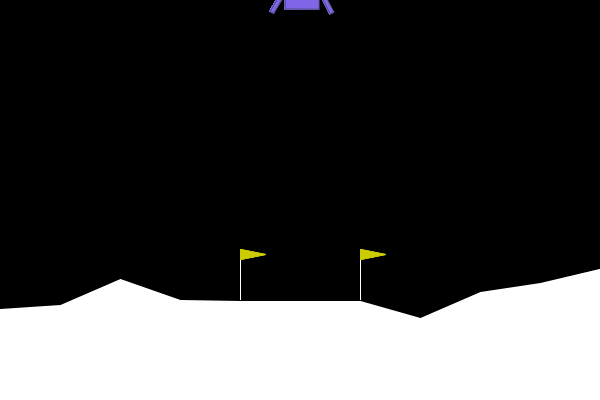

In [7]:
env.reset()
PIL.Image.fromarray(env.render())

In [8]:
state_size = env.observation_space.shape
num_actions = env.action_space.n

In [9]:
initial_state, _ = env.reset()
print(initial_state)
initial_state = np.reshape(initial_state, (-1, 1))
print(initial_state.shape)

action = 0
next_state, reward, terminated, truncated, info = env.step(action)

[ 1.9149781e-04  1.4215063e+00  1.9388419e-02  4.7050065e-01
 -2.1519289e-04 -4.3917852e-03  0.0000000e+00  0.0000000e+00]
(8, 1)


In [10]:
# Target Network
# Using another neural network to get y target (same architecture as Q-network)

# Soft update
# Every C time steps, we will update weights of Q-target-network using tau
# w- = tau*w + (1-tau)*w- (tau << 1)

q_network = Sequential([
    Input(shape=state_size),
    Dense(units=64, activation='relu'),
    Dense(units=64, activation='relu'),
    Dense(units=num_actions, activation='linear'),
])

target_q_network = Sequential([
    Input(shape=state_size),
    Dense(units=64, activation='relu'),
    Dense(units=64, activation='relu'),
    Dense(units=num_actions, activation='linear'),
])

optimizer = Adam(learning_rate=ALPHA)

In [11]:
# Experience replay
# To solve problem due to strong correlation between experiences
# Sample random mini-batch of experiences from a buffer that stores previous experiences

experience = namedtuple('Experience', field_names=['state', 'action', 'reward', 'next_state', 'done'])


Calculate target y:

$$
\begin{equation}
    y_j =
    \begin{cases}
      R_j & \text{if episode terminates at step  } j+1\\
      R_j + \gamma \max_{a'}\hat{Q}(s_{j+1},a') & \text{otherwise}\\
    \end{cases}       
\end{equation}
$$

In [12]:
def compute_loss(experiences, gamma, q_network, target_q_network):
    states, actions, rewards, next_states, done_vals = experiences
    max_qsa = tf.reduce_max(target_q_network(next_states), axis=-1)
    y_targets = rewards + (gamma * max_qsa * (1 - done_vals))
    
    # gather_nd: get specific tensors from list
    # stack: stack tensors of whichever dimension along a specified axis, 0 by default
    q_values = q_network(states) # returns nstates * nactions
    q_values = tf.gather_nd(q_values, tf.stack([tf.range(q_values.shape[0]),
                                                tf.cast(actions, tf.int32)], axis=1))
    loss = MSE(y_targets, q_values)
    return loss
    
    # q_values = array of tensors object that has parameter s (state), and a (action)
    # Q(s, a)

In [13]:
# @ is used for 1> change type of a function
# 2>
# when you have created a function inside another function and return
# the function created inside
# the equivalent: agent_learn = tf.function(agent_learn)
# in short, tf.function makes function run faster by first compiles computation graph
# of every TensorFlow operations before executing it
# however, not every Python code executes when wrapping function inside tf.function

# warning: be careful when using global variable, Python function inside function
# should pass variable as parameter
@tf.function
def agent_learn(experiences, gamma, tau):
    """
    Updates the weights of the Q networks.
    
    Args:
      experiences: (tuple) tuple of ["state", "action", "reward", "next_state", "done"] namedtuples
      gamma: (float) The discount factor.
      tau: (float) Soft update parameter
    
    """
    
    # automatic differentiation
    with tf.GradientTape() as tape:
        loss = compute_loss(experiences, gamma, q_network, target_q_network)
    
    # get gradients of the loss respect to the weights
    gradients = tape.gradient(loss, q_network.trainable_variables)
    
    # update weights of q_network
    optimizer.apply_gradients(zip(gradients, q_network.trainable_variables))
    
    # soft update
    for target_weights, q_net_weights in zip(target_q_network.weights, q_network.weights):
        target_weights.assign(tau*q_net_weights + (1.0-tau)*target_weights)
    

## Utils functions

In [14]:
def check_update_conditions(t, num_steps_upd, memory_buffer):
    if (t + 1) % num_steps_upd == 0 and len(memory_buffer) > MINIBATCH_SIZE:
        return True
    else:
        return False
    
def get_experiences(memory_buffer):
    experiences = random.sample(memory_buffer, k=MINIBATCH_SIZE)
    states = tf.convert_to_tensor(np.array([e.state for e in experiences if e is not None]),dtype=tf.float32)
    actions = tf.convert_to_tensor(np.array([e.action for e in experiences if e is not None]), dtype=tf.float32)
    rewards = tf.convert_to_tensor(np.array([e.reward for e in experiences if e is not None]), dtype=tf.float32)
    next_states = tf.convert_to_tensor(np.array([e.next_state for e in experiences if e is not None]),dtype=tf.float32)
    done_vals = tf.convert_to_tensor(np.array([e.done for e in experiences if e is not None]).astype(np.uint8),
                                     dtype=tf.float32)
    return (states, actions, rewards, next_states, done_vals)

def get_new_eps(epsilon):
    return max(E_MIN, E_DECAY*epsilon)

## DQN + RL

Deep Q-Learning with Experience Replay: [Link](https://raw.githubusercontent.com/greyhatguy007/Machine-Learning-Specialization-Coursera/931b5ff0a80abc1317c6438581e3594faea89326/C3%20-%20Unsupervised%20Learning,%20Recommenders,%20Reinforcement%20Learning/week3/C3W3A1/images/deep_q_algorithm.png)

In [15]:
# important variables:
# e-initial, e-min, e-decay; C (steps/learning update), minibatch-size; gamma, tau

# use deque as structure for memory_buffer
tf.random.set_seed(SEED)
start = time.time()

num_episodes = 2000 # number of maximum steps
max_num_timesteps = 1000
total_point_history = []

num_p_av = 100
epsilon = 1.0 # initial value for epsilon greedy policy, probability to choose random action


memory_buffer = deque(maxlen=MEMORY_SIZE)

target_q_network.set_weights(q_network.get_weights())

for i in range(num_episodes):
    state, _ = env.reset()
    total_points = 0
    for t in range(max_num_timesteps):
        state = state
        # Choose step using epsilon greedy policy:
        # expand dims as q_network requires 2D NumPy array
        state_qn = np.reshape(state, (1, -1)) # expect shape (1, 8)
        
        q_values = q_network(state_qn)
        # returns 2D tensorflow array?
        action = 0
        if random.random() > epsilon:
            action = np.argmax(q_values.numpy()[0])
        else:
            action = random.choice(np.arange(4)) #num_actions
        
        next_state, reward, terminated, truncated, info = env.step(action)
        done = terminated or truncated
        memory_buffer.append(experience(state, action, reward, next_state, done))
        
        update = check_update_conditions(t, NUM_STEPS_FOR_UPDATE, memory_buffer)
        if update:
            experiences = get_experiences(memory_buffer)
            agent_learn(experiences, GAMMA, TAU)
        
        state = next_state.copy()
        total_points += reward
        
        if done:
            break
        
    total_point_history.append(total_points)
    av_latest_points = np.mean(total_point_history[-num_p_av:])
        
    epsilon = get_new_eps(epsilon)
    print(f"\rEpisode {i+1} | Total point average of the last {num_p_av} episodes: {av_latest_points:.2f}", end="")
    if (i+1) % num_p_av == 0:
        print(f"\rEpisode {i+1} | Total point average of the last {num_p_av} episodes: {av_latest_points:.2f}")
        
    if av_latest_points >= 200.0:
        print(f"\n\nEnvironment solved in {i+1} episodes!")
        q_network.save('lunar_lander_model.h5')
        break
        
tot_time = time.time() - start
print(f"\nTotal Runtime: {tot_time:.2f} s ({(tot_time/60):.2f} min)")

Episode 100 | Total point average of the last 100 episodes: -157.57
Episode 200 | Total point average of the last 100 episodes: -57.44
Episode 300 | Total point average of the last 100 episodes: -3.13
Episode 400 | Total point average of the last 100 episodes: 124.27
Episode 473 | Total point average of the last 100 episodes: 200.93

Environment solved in 473 episodes!

Total Runtime: 1189.01 s (19.82 min)


## Plot history

In [16]:
def plot_history(reward_history, rolling_window=20, lower_limit=None,
                 upper_limit=None, plot_rw=True, plot_rm=True):
    
    if lower_limit is None or upper_limit is None:
        rh = reward_history
        xs = [x for x in range(len(reward_history))]
    else:
        rh = reward_history[lower_limit:upper_limit]
        xs = [x for x in range(lower_limit,upper_limit)]
    
    df = pd.DataFrame(rh)
    rollingMean = df.rolling(rolling_window).mean()

    plt.figure(figsize=(10,7), facecolor='white')
    
    if plot_rw:
        plt.plot(xs, rh, linewidth=1, color='cyan')
    if plot_rm:
        plt.plot(xs, rollingMean, linewidth=2, color='magenta')

    text_color = 'black'
        
    ax = plt.gca()
    ax.set_facecolor('black')
    plt.grid()
#     plt.title("Total Point History", color=text_color, fontsize=40)
    plt.xlabel('Episode', color=text_color, fontsize=30)
    plt.ylabel('Total Points', color=text_color, fontsize=30)
    yNumFmt = mticker.StrMethodFormatter('{x:,}')
    ax.yaxis.set_major_formatter(yNumFmt)
    ax.tick_params(axis='x', colors=text_color)
    ax.tick_params(axis='y', colors=text_color)
    plt.show()

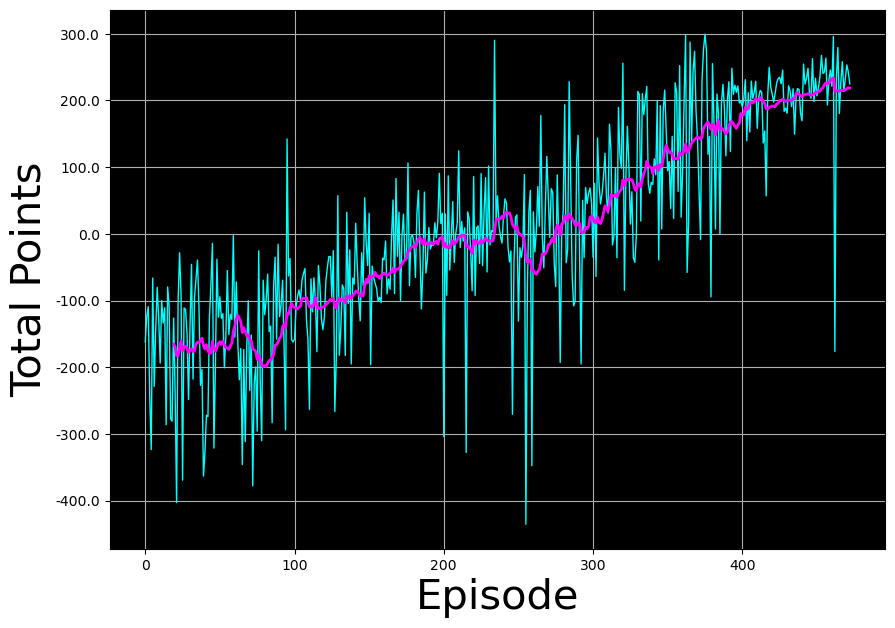

In [17]:
plot_history(total_point_history)

## Create video

In [18]:
import logging
logging.getLogger().setLevel(logging.ERROR)
import base64
import IPython
import imageio

def embed_mp4(filename):
    """Embeds an mp4 file in the notebook."""
    video = open(filename,'rb').read()
    b64 = base64.b64encode(video)
    tag = '''
    <video width="840" height="480" controls>
    <source src="data:video/mp4;base64,{0}" type="video/mp4">
    Your browser does not support the video tag.
    </video>'''.format(b64.decode())
    return IPython.display.HTML(tag)

def create_video(filename, env, q_network, fps=30):
    total_reward = 0
    with imageio.get_writer(filename, fps=fps) as video:
        done = False
        state, _ = env.reset()
        frame = env.render()
        video.append_data(frame)
        while not done:    
            state = np.expand_dims(state, axis=0)
            q_values = q_network(state)
            action = np.argmax(q_values.numpy()[0])
            state, reward, terminated, truncated, _ = env.step(action)
            total_reward += reward
            done = terminated or truncated
            frame = env.render()
            video.append_data(frame)
        print(f"Final reward is {total_reward}")

In [19]:
filename = "/kaggle/working/lunar_lander.mp4"

create_video(filename, env, q_network)
embed_mp4(filename)

[swscaler @ 0x6788600] Warning: data is not aligned! This can lead to a speed loss


Final reward is 206.99169863798198
